In [63]:
import numpy as np
import pywt
from skimage import io
from skimage.color import rgb2ycbcr, ycbcr2rgb
import matplotlib.pyplot as plt
import arithmeticcoding as ac
import pickle

def read_image(image_path):
    image = io.imread(image_path)
    if image.shape[2] == 4:
        image = image[:, :, :3]
    image = image[:400, :400, :]
    print("Image shape after reading:", image.shape)
    return image

def preprocess_image(image):
    ycbcr_image = rgb2ycbcr(image)
    print("Image shape after converting to YCbCr:", ycbcr_image.shape)
    ycbcr_image = ycbcr_image - 128
    return ycbcr_image

def dwt_image(image, wavelet='haar', level=3):
    return pywt.wavedec2(image, wavelet=wavelet, level=level)

# Quantization function
def quantize(coeffs, base_delta, num_levels):
    quantized_coeffs = []
    for i, channel_coeffs in enumerate(coeffs):
        if i == 0:  # The first element is the approximation coefficients
            LL = channel_coeffs
            delta_LL = base_delta / (2 ** num_levels)
            LL = np.sign(LL) * np.floor(np.abs(LL) / delta_LL)
            quantized_coeffs.append(LL)
        else:  # Subsequent elements are detail coefficients
            LH, HL, HH = channel_coeffs
            delta_LH_HL_HH = base_delta / (2 ** (num_levels - i + 1))
            LH = np.sign(LH) * np.floor(np.abs(LH) / delta_LH_HL_HH)
            HL = np.sign(HL) * np.floor(np.abs(HL) / delta_LH_HL_HH)
            HH = np.sign(HH) * np.floor(np.abs(HH) / delta_LH_HL_HH)
            quantized_coeffs.append((LH, HL, HH))
    return quantized_coeffs

def inverse_quantize(coeffs, base_delta, num_levels):
    inverse_quantized_coeffs = []
    for i, channel_coeffs in enumerate(coeffs):
        if i == 0:  # The first element is the approximation coefficients
            LL = channel_coeffs
            delta_LL = base_delta / (2 ** num_levels)
            LL = LL * delta_LL
            inverse_quantized_coeffs.append(LL)
        else:  # Subsequent elements are detail coefficients
            LH, HL, HH = channel_coeffs
            delta_LH_HL_HH = base_delta / (2 ** (num_levels - i + 1))
            LH = LH * delta_LH_HL_HH
            HL = HL * delta_LH_HL_HH
            HH = HH * delta_LH_HL_HH
            inverse_quantized_coeffs.append((LH, HL, HH))
    return inverse_quantized_coeffs



def postprocess_image(image):
    image = image + 128
    np.clip(image, 0, 255, out=image)  # Ensure values are within the valid range
    rgb_image = ycbcr2rgb(image)
    rgb_image = (rgb_image * 255).clip(0, 255)  # Scale back to [0, 255]
    print("Image shape after converting back to RGB:", rgb_image.shape)
    return rgb_image

def display_image(image):
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.show()

def flatten_coeffs(coeffs, num_levels):
    flattened = []
    shapes = []
    
    for channel in coeffs:
        channel_shapes = []
        channel_flattened = []

        for level in range(num_levels + 1):  # Iterate through all levels including the final approximation level
            if level == 0:
                LL = channel[0]
                channel_shapes.append(LL.shape)
                channel_flattened.extend(LL.flatten())
            else:
                LH, HL, HH = channel[level]
                channel_shapes.append((LH.shape, HL.shape, HH.shape))
                channel_flattened.extend(LH.flatten())
                channel_flattened.extend(HL.flatten())
                channel_flattened.extend(HH.flatten())

        flattened.extend(channel_flattened)
        shapes.append(channel_shapes)
    
    return flattened, shapes



def reshape_coeffs(flattened, coeffs_shapes, num_levels):
    reshaped = []
    idx = 0

    for channel_shapes in coeffs_shapes:
        channel_coeffs = []
        
        for level, shape in enumerate(channel_shapes):
            if level == 0:
                LL_shape = shape
                LL = np.reshape(flattened[idx:idx + np.prod(LL_shape)], LL_shape)
                idx += np.prod(LL_shape)
                channel_coeffs.append(LL)
            else:
                LH_shape, HL_shape, HH_shape = shape
                LH = np.reshape(flattened[idx:idx + np.prod(LH_shape)], LH_shape)
                idx += np.prod(LH_shape)
                HL = np.reshape(flattened[idx:idx + np.prod(HL_shape)], HL_shape)
                idx += np.prod(HL_shape)
                HH = np.reshape(flattened[idx:idx + np.prod(HH_shape)], HH_shape)
                idx += np.prod(HH_shape)
                channel_coeffs.append((LH, HL, HH))
        
        reshaped.append(channel_coeffs)
    
    return reshaped


def get_coeffs_shapes(coeffs):
    shapes = []
    for channel in coeffs:
        LL, (LH, HL, HH) = channel
        shapes.append((LL.shape, LH.shape, HL.shape, HH.shape))
    return shapes

def entropy_encode(coeffs):
    flattened_coeffs, shapes = flatten_coeffs(coeffs, 3)
    
    # Initialize a flat frequency table with 256 symbols (0 to 255)
    initfreqs = ac.FlatFrequencyTable(257)
    freqs = ac.SimpleFrequencyTable(initfreqs)
    
    # Initialize list to store encoded bits
    encoded_bits = []
    
    # Initialize bit output stream
    with open('encoded_bits.bin', 'wb') as output_file:
        bitout = ac.BitOutputStream(output_file)
        
        # Initialize arithmetic encoder with a state size of 32 bits
        encoder = ac.ArithmeticEncoder(32, bitout)
        
        # Encoding loop
        for coeff in flattened_coeffs:
            sign = 1 if coeff < 0 else 0
            magnitude = int(abs(coeff))  # Convert magnitude to integer
            
            # Encode sign
            encoder.write(freqs, sign)
            
            # Encode magnitude
            for _ in range(magnitude):
                encoder.write(freqs, 1)
            
            encoder.write(freqs, 0)  # End of magnitude encoding
        
        encoder.write(freqs, 256)  # EOF (end-of-file) symbol
        encoder.finish()  # Flush remaining bits
    
    # Read encoded bits from file and store them in the list
    with open('encoded_bits.bin', 'rb') as input_file:
        byte = input_file.read(1)
        while byte:
            encoded_bits.append(ord(byte))
            byte = input_file.read(1)  # Read next byte
    
    return encoded_bits, shapes

### Stream bit organization
def bitstream_organization(encoded_bits, coeffs_shapes, quantization_steps):
    """
    Organizes the encoded bits into a JPEG 2000 compliant bit-stream.
    """
    bitstream = []

    # Step 1: Create main header
    bitstream.extend(create_main_header())

    # Step 2: Create tile headers
    for channel_idx, shape in enumerate(coeffs_shapes):
        bitstream.extend(create_tile_header(channel_idx, shape, quantization_steps[channel_idx]))

    # Step 3: Organize encoded bits into packets
    packet_idx = 0
    while packet_idx < len(encoded_bits):
        # Create packet header
        packet_header = create_packet_header(packet_idx)
        bitstream.extend(packet_header)

        # Append packet data (slice of encoded bits)
        packet_data = encoded_bits[packet_idx:packet_idx + 1024]  # Example packet size of 1024 bits
        bitstream.extend(packet_data)

        packet_idx += 1024

    return bitstream

def create_main_header():
    """
    Creates the main header for the JPEG 2000 bit-stream.
    """
    header = []
    header.append(0xFF4F)  # SOC (Start of codestream)
    header.extend(create_image_and_tile_size_header())
    header.extend(create_image_characteristics_header())
    return header

def create_image_and_tile_size_header():
    """
    Creates the image and tile size header.
    """
    header = []
    header.append(0xFF51)  # SIZ marker
    header.extend([0, 0, 1, 0, 1, 0, 0, 0, 100, 0, 0, 0, 100, 0, 0, 0])  # Image size and other parameters
    return header

def create_image_characteristics_header():
    """
    Creates the image characteristics header.
    """
    header = []
    header.append(0xFF52)  # COD marker
    header.extend([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1])  # Coding parameters
    return header

def create_tile_header(channel_idx, shape, quantization_step):
    """
    Creates the tile header for a specific channel and shape.
    """
    header = []
    header.append(0xFF53)  # Tile-part header
    header.extend([channel_idx, *shape[0], *shape[1], *shape[2], *shape[3]])  # Shape and quantization
    header.extend(quantization_step)
    return header

def create_packet_header(packet_idx):
    """
    Creates the packet header for a specific packet index.
    """
    header = []
    header.append(0xFF90 + packet_idx)  # Packet header
    header.extend([0, 1, 2, 3])  # Example packet header data
    return header


def bitstream_parsing(bitstream):
    """
    Parses the JPEG 2000 bit-stream to retrieve the encoded bits, shapes, and quantization steps.
    """
    idx = 0

    # Step 1: Parse main header
    assert bitstream[idx] == 0xFF4F, "Invalid main header"
    idx += 1
    idx += len(create_image_and_tile_size_header())
    idx += len(create_image_characteristics_header())

    # Step 2: Parse tile headers
    coeffs_shapes = []
    quantization_steps = []
    while bitstream[idx] == 0xFF53:
        idx += 1
        channel_idx = bitstream[idx]
        idx += 1
        shape_LL = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        shape_LH = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        shape_HL = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        shape_HH = (bitstream[idx], bitstream[idx + 1])
        idx += 2
        coeffs_shapes.append((shape_LL, shape_LH, shape_HL, shape_HH))
        quantization_step = (bitstream[idx], bitstream[idx + 1], bitstream[idx + 2], bitstream[idx + 3])
        idx += 4
        quantization_steps.append(quantization_step)

    # Step 3: Parse packets to get encoded bits
    encoded_bits = []
    while idx < len(bitstream):
        if bitstream[idx] >= 0xFF90:
            idx += 1
            packet_header_size = 4  # Assuming fixed packet header size
            idx += packet_header_size
        packet_data = bitstream[idx:idx + 1024]
        encoded_bits.extend(packet_data)
        idx += 1024

    return encoded_bits, coeffs_shapes, quantization_steps

def entropy_decode(encoded_bits):
    with open('encoded_bits.bin', 'wb') as output_file:
        output_file.write(bytearray(encoded_bits))
    
    with open('encoded_bits.bin', 'rb') as input_file:
        bitin = ac.BitInputStream(input_file)
        initfreqs = ac.FlatFrequencyTable(257)
        freqs = ac.SimpleFrequencyTable(initfreqs)
        decoder = ac.ArithmeticDecoder(32, bitin)
        
        decoded_coeffs = []
        while True:
            sign = decoder.read(freqs)
            if sign == 256:
                break
            magnitude = 0
            while True:
                bit = decoder.read(freqs)
                if bit == 0:
                    break
                magnitude += 1
            decoded_coeffs.append(((-1) ** sign) * magnitude)
        
    return decoded_coeffs




def idwt_image(coeffs, wavelet='haar'):
    return pywt.waverec2(coeffs, wavelet=wavelet)

def postprocess_image(image):
    image = image + 128
    np.clip(image, 0, 255, out=image)
    rgb_image = ycbcr2rgb(image)
    rgb_image = (rgb_image * 255).clip(0, 255)
    return rgb_image

Image shape after reading: (400, 400, 3)


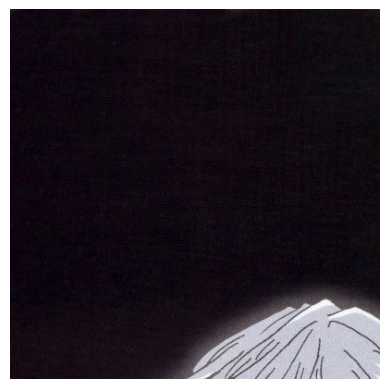

Image shape after converting to YCbCr: (400, 400, 3)


In [33]:
image_path = 'C:\\Users\\saioc\\Desktop\\New folder\\B8sUPsb.jpeg'
image = read_image(image_path)
display_image(image)
#print(image)
preprocessed_image = preprocess_image(image)

num_levels = 3
base_delta = 10

# Perform DWT
coeffs = dwt_image(image, wavelet='haar', level=num_levels)

# Quantize
quantized_coeffs = quantize(coeffs, base_delta, num_levels)



# Define quantization steps for different subbands
quantization_steps = [
    (0.67188, 1.05209, 5.37500, 8.41675),  
    (0.72992, 1.04584, 2.91966, 4.18337),  
    (0.72992, 1.04584, 2.91966, 4.18337),
    (0.79297, 1.03963, 1.58594, 2.07926),
    ( 0.79611, 0.99841, 1.59222, 1.99681),
    ( 0.79611, 0.99841, 1.59222, 1.99681),
    ( 0.92188, 0.96722, 0.92188, 0.96722),
    ( 1.03833, 1.01129, 1.03833, 1.01129),
    ( 1.03833, 1.01129, 1.03833, 1.01129),
    (1.43750, 1.04044, 0.71875, 0.52022)
]



In [64]:

encoded_bits, shapes = entropy_encode(quantized_coeffs)

ValueError: too many values to unpack (expected 3)

In [79]:
bitstream = bitstream_organization(encoded_bits, shapes, quantization_steps)
print(len(bitstream))
print(bitstream[:100])  # Print the first 100 bits of the bitstream for verification

[65359, 65361, 0, 0, 1, 0, 1, 0, 0, 0, 100, 0, 0, 0, 100, 0, 0, 0, 65362, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 65363, 0, 204, 204, 204, 204, 204, 204, 204, 204, 10, 10, 10, 10, 65363, 1, 204, 204, 204, 204, 204, 204, 204, 204, 10, 10, 10, 10, 65363, 2, 204, 204, 204, 204, 204, 204, 204, 204, 10, 10, 10, 10, 65424, 0, 1, 2, 3, 0, 255, 255, 255, 254, 251, 245, 234, 220, 201, 173, 136, 92, 38, 231, 153, 64, 219, 100, 225, 73]


In [81]:
####### Decoder 
dencoded_bits, dshapes, dquantization_steps = bitstream_parsing(bitstream)



In [82]:

print(encoded_bits[:100])
print(dencoded_bits[:100])

[0, 255, 255, 255, 254, 251, 245, 234, 220, 201, 173, 136, 92, 38, 231, 153, 64, 219, 100, 225, 73, 185, 11, 224, 63, 73, 62, 27, 224, 142, 34, 157, 251, 61, 97, 104, 78, 22, 190, 68, 169, 231, 43, 167, 85, 120, 253, 88, 136, 145, 109, 29, 161, 247, 33, 27, 228, 127, 231, 29, 30, 239, 137, 37, 220, 63, 213, 93, 171, 190, 152, 55, 151, 189, 163, 75, 179, 219, 194, 103, 201, 235, 198, 94, 249, 59, 129, 254, 53, 34, 197, 29, 43, 237, 99, 139, 101, 243, 47, 27]
[0, 255, 255, 255, 254, 251, 245, 234, 220, 201, 173, 136, 92, 38, 231, 153, 64, 219, 100, 225, 73, 185, 11, 224, 63, 73, 62, 27, 224, 142, 34, 157, 251, 61, 97, 104, 78, 22, 190, 68, 169, 231, 43, 167, 85, 120, 253, 88, 136, 145, 109, 29, 161, 247, 33, 27, 228, 127, 231, 29, 30, 239, 137, 37, 220, 63, 213, 93, 171, 190, 152, 55, 151, 189, 163, 75, 179, 219, 194, 103, 201, 235, 198, 94, 249, 59, 129, 254, 53, 34, 197, 29, 43, 237, 99, 139, 101, 243, 47, 27]


In [83]:
print(len(encoded_bits))
print(len(dencoded_bits))

1807025
1807025


In [84]:
decoded_flat_coeffs = entropy_decode(dencoded_bits)

In [85]:

print(quantized_coeffs[:100])
print(decoded_flat_coeffs[:100])

[(array([[-19., -19., -19., ..., -19., -19., -19.],
       [-18., -18., -17., ..., -18., -18., -18.],
       [-17., -16., -16., ..., -17., -16., -17.],
       ...,
       [-20., -20., -20., ...,  18.,  18.,  16.],
       [-20., -20., -20., ...,  16.,  19.,  13.],
       [-20., -20., -21., ...,  18.,  16.,  18.]]), (array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., -0., -1.,  0.],
       [-0., -0.,  0., ...,  0.,  0., -0.]]), array([[ 0., -0., -0., ..., -0.,  0.,  0.],
       [ 0., -0., -0., ..., -0.,  0., -0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       ...,
       [ 0.,  0., -0., ...,  0., -1., -0.],
       [ 0., -0., -0., ..., -0., -0., -1.],
       [ 0.,  0., -0., ...,  0., -1., -0.]]), array([[-0.,  0., -0., ...,  0., -0., -0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       [-0.,  0., -0., ..., -0.,  0.,  

In [86]:
reshaped_coeffs = reshape_coeffs(decoded_flat_coeffs, shapes, 3)

print(quantized_coeffs[:100])
print(reshaped_coeffs[:100])

[(array([[-19., -19., -19., ..., -19., -19., -19.],
       [-18., -18., -17., ..., -18., -18., -18.],
       [-17., -16., -16., ..., -17., -16., -17.],
       ...,
       [-20., -20., -20., ...,  18.,  18.,  16.],
       [-20., -20., -20., ...,  16.,  19.,  13.],
       [-20., -20., -21., ...,  18.,  16.,  18.]]), (array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., -0., -1.,  0.],
       [-0., -0.,  0., ...,  0.,  0., -0.]]), array([[ 0., -0., -0., ..., -0.,  0.,  0.],
       [ 0., -0., -0., ..., -0.,  0., -0.],
       [ 0.,  0., -0., ..., -0.,  0., -0.],
       ...,
       [ 0.,  0., -0., ...,  0., -1., -0.],
       [ 0., -0., -0., ..., -0., -0., -1.],
       [ 0.,  0., -0., ...,  0., -1., -0.]]), array([[-0.,  0., -0., ...,  0., -0., -0.],
       [ 0., -0.,  0., ...,  0., -0., -0.],
       [-0.,  0., -0., ..., -0.,  0.,  

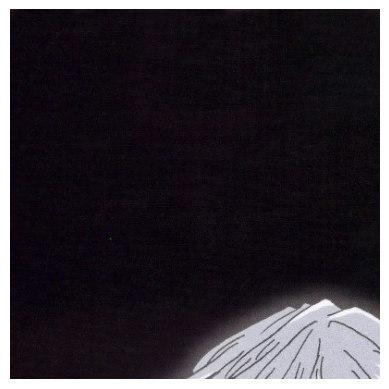

In [57]:

inverse_quantized_coeffs = inverse_quantize(decoded_flat_coeffs,  base_delta, num_levels)
inverse_idt = idwt_image(inverse_quantized_coeffs)
postprocessed_image = inverse_idt[:,:,:3]
display_image(postprocessed_image)
#print(postprocessed_image)

In [58]:

from numpy import std

i1=image
i2=postprocessed_image

std(i1-i2)

1.5051784836752458

In [24]:
# e-14 dupa procesare
# e-11 dupa idwt
# 5.48 dupa quantizare
# 5.48 dupa entropy encoding
# 5.48 dupa bitstream organization

[(array([[-191.92523178, -193.28781276, -190.19678097, ..., -188.57862535,
        -186.94609307, -189.91023873],
       [-181.12617896, -177.54407355, -173.07176662, ..., -180.06350632,
        -175.60450909, -181.87030654],
       [-174.86292792, -163.24939624, -162.67192707, ..., -167.19117034,
        -160.81520404, -170.52815963],
       ...,
       [-199.37030961, -199.22984475, -200.1809429 , ...,  191.53296174,
         194.94131174,  168.20634927],
       [-200.02609332, -198.33139395, -195.66661033, ...,  173.76528599,
         200.36151352,  141.47564507],
       [-197.19671166, -199.3173739 , -205.44003918, ...,  188.96594878,
         165.5678306 ,  189.68364411]]), (array([[  0.45695975,   2.2209844 ,   0.70404437, ...,   2.18331718,
          2.46766732,   1.75935071],
       [ -1.43200711,  -3.47585212,  -2.37005313, ...,  -3.6147746 ,
         -4.02137164,  -3.1738315 ],
       [  1.32465314,   2.06678595,   1.68123265, ...,   2.79060781,
          3.00241085,   2.5057

In [27]:
coeffs

[array([[[ 254.  ],
         [ 156.  ],
         [ 110.25],
         ...,
         [ 190.5 ],
         [ 242.  ],
         [ 284.25]],
 
        [[ 204.  ],
         [ 132.  ],
         [  71.25],
         ...,
         [ 152.5 ],
         [ 199.  ],
         [ 216.  ]],
 
        [[ 164.5 ],
         [ 116.  ],
         [  91.  ],
         ...,
         [ 142.  ],
         [ 185.5 ],
         [ 177.  ]],
 
        ...,
 
        [[ 134.  ],
         [ 124.  ],
         [ 133.  ],
         ...,
         [1522.5 ],
         [1409.5 ],
         [1747.  ]],
 
        [[ 139.  ],
         [ 125.  ],
         [ 131.  ],
         ...,
         [1443.5 ],
         [1386.  ],
         [1750.5 ]],
 
        [[ 151.  ],
         [ 129.  ],
         [ 126.  ],
         ...,
         [1410.  ],
         [1391.25],
         [1738.25]]]),
 (array([[[  29.  ],
          [  16.  ],
          [  -1.75],
          ...,
          [ -12.5 ],
          [ -12.  ],
          [   3.75]],
  
         [[  19.  

In [28]:
approximation_coeffs = coeffs[0]  # Coarsest approximation coefficients (LL at the highest level)
detail_coeffs_level1 = coeffs[1]  # Detail coefficients (LH, HL, HH) at level 1
detail_coeffs_level2 = coeffs[2]  # Detail coefficients (LH, HL, HH) at level 2
detail_coeffs_level3 = coeffs[3]  # Detail coefficients (LH, HL, HH) at level 3

In [29]:
detail_coeffs_level3

(array([[[ -2. ,  -2. ],
         [  2. ,   2. ],
         [  3. ,   3. ],
         ...,
         [ -2. ,  -2. ],
         [  2. ,   2. ],
         [ -4.5,  -2. ]],
 
        [[  1. ,   1. ],
         [ -3. ,  -3. ],
         [  6. ,   6. ],
         ...,
         [ -1. ,  -1. ],
         [  2. ,   2. ],
         [ -3. ,  -3. ]],
 
        [[  3. ,   3. ],
         [ -6. ,  -6. ],
         [  9. ,   9. ],
         ...,
         [  0. ,   0. ],
         [  1. ,   1. ],
         [ -2. ,  -2. ]],
 
        ...,
 
        [[ -5. ,  -5. ],
         [ -2. ,  -2. ],
         [ -7. ,  -7. ],
         ...,
         [ 13. ,  13. ],
         [-29. , -29. ],
         [ 24. ,  24. ]],
 
        [[ -1. ,  -1. ],
         [ -3. ,  -3. ],
         [ -7. ,  -7. ],
         ...,
         [ 17. ,  17. ],
         [-12. , -12. ],
         [ -7. ,  -4. ]],
 
        [[  1. ,   1. ],
         [ -4. ,  -4. ],
         [ -7. ,  -7. ],
         ...,
         [ 25.5,  25. ],
         [ -1. ,  -3. ],
         [-

In [34]:
quantized_coeffs

[array([[[ 203.],
         [ 124.],
         [  88.],
         ...,
         [ 152.],
         [ 193.],
         [ 227.]],
 
        [[ 163.],
         [ 105.],
         [  57.],
         ...,
         [ 122.],
         [ 159.],
         [ 172.]],
 
        [[ 131.],
         [  92.],
         [  72.],
         ...,
         [ 113.],
         [ 148.],
         [ 141.]],
 
        ...,
 
        [[ 107.],
         [  99.],
         [ 106.],
         ...,
         [1218.],
         [1127.],
         [1397.]],
 
        [[ 111.],
         [ 100.],
         [ 104.],
         ...,
         [1154.],
         [1108.],
         [1400.]],
 
        [[ 120.],
         [ 103.],
         [ 100.],
         ...,
         [1128.],
         [1113.],
         [1390.]]]),
 (array([[[  23.],
          [  12.],
          [  -1.],
          ...,
          [ -10.],
          [  -9.],
          [   2.]],
  
         [[  15.],
          [  12.],
          [  -8.],
          ...,
          [ -13.],
          [

In [45]:
inverse_idt

array([[[ 43.4375 ,  33.4375 ,  37.1875 ,  37.1875 ],
        [ 43.4375 ,  33.4375 ,  37.1875 ,  37.1875 ],
        [ 37.1875 ,  27.1875 ,  33.4375 ,  33.4375 ],
        ...,
        [ 39.53125,  29.53125,  33.28125,  33.28125],
        [ 42.03125,  32.03125,  35.78125,  35.78125],
        [ 42.03125,  32.03125,  35.78125,  35.78125]],

       [[ 34.6875 ,  24.6875 ,  28.4375 ,  28.4375 ],
        [ 34.6875 ,  24.6875 ,  28.4375 ,  28.4375 ],
        [ 30.9375 ,  20.9375 ,  27.1875 ,  27.1875 ],
        ...,
        [ 31.40625,  21.40625,  25.15625,  25.15625],
        [ 32.65625,  22.65625,  26.40625,  26.40625],
        [ 32.65625,  22.65625,  26.40625,  26.40625]],

       [[ 29.0625 ,  19.0625 ,  24.0625 ,  24.0625 ],
        [ 29.0625 ,  19.0625 ,  24.0625 ,  24.0625 ],
        [ 24.0625 ,  14.0625 ,  19.0625 ,  19.0625 ],
        ...,
        [ 24.53125,  19.53125,  20.78125,  20.78125],
        [ 24.53125,  19.53125,  20.78125,  20.78125],
        [ 24.53125,  19.53125,  20.7812

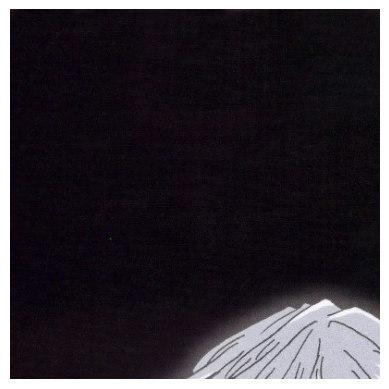

In [54]:
display_image(inverse_idt[:,:,:3])

(400, 400, 3)